In [3]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from keras.layers import Layer
import warnings
warnings.simplefilter('ignore', FutureWarning)

2025-06-20 22:25:04.745232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Sample parallel sentences (English -> Spanish)
input_texts = [
    "Hello.", "How are you?", "I am learning machine translation.", "What is your name?", "I love programming."
]
target_texts = [
    "Hola.", "¿Cómo estás?", "Estoy aprendiendo traducción automática.", "¿Cuál es tu nombre?", "Me encanta programar."
]

target_texts = ["startseq " + x + " endseq" for x in target_texts]

In [5]:
# Tokenization
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_texts)
output_sequences = output_tokenizer.texts_to_sequences(target_texts)

input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

In [6]:
# Padding
max_input_length = max([len(seq) for seq in input_sequences])
max_output_length = max([len(seq) for seq in output_sequences])

input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

In [7]:
# Prepare the target data for training
decoder_input_data = output_sequences[:, :-1]
decoder_output_data = output_sequences[:, 1:]

# Convert to one-hot
decoder_output_data = np.array([np.eye(output_vocab_size)[seq] for seq in decoder_output_data])

In [8]:
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.Wq = None
        self.Wk = None
        self.Wv = None

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Weights matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Calculate Dot Product
        q = K.dot(inputs, self.Wq) # Q
        k = K.dot(inputs, self.Wk) # K
        v = K.dot(inputs, self.Wv) # V

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))
        attention_weights = K.softmax(scores, axis=-1)

        output = K.batch_dot(attention_weights, v)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

In [9]:
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

In [10]:
attention_layer = SelfAttention()(encoder_outputs)

In [11]:
decoder_inputs = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_attention = SelfAttention()(decoder_outputs)  # Apply attention
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_attention)

In [12]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 5, 256)    │      4,096 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 5, 256)    │      4,352 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 5, 256),  │    525,312 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 5, 256),  │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_1    │ (None, 5, 256)    │    196,608 │ lstm_1[0][0]      │
│ (SelfAttention)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5, 17)     │      4,369 │ self_attention_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,260,049 (4.81 MB)

 Trainable params: 1,260,049 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history_glorot_adam = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0000e+00 - loss: 2.8347
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2800 - loss: 2.7975
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2800 - loss: 2.7550
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2800 - loss: 2.6965
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2800 - loss: 2.6120
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2400 - loss: 2.4948
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2400 - loss: 2.3607
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2400 - loss: 2.3137
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2400 - loss: 2.3696
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2800 - loss: 2.3089
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3200 - loss: 2.2299
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3200 - 

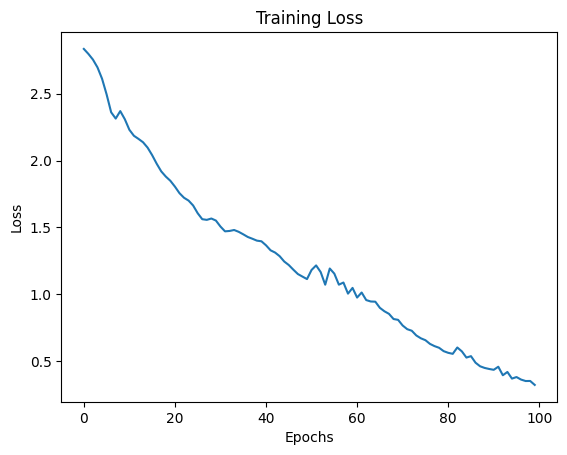

In [15]:
# Plotting training loss
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()